# Sweeps - Impedance, scattering and admittance (Z S Y) matrices

### Prerequisite
You need to have a working local installation of Ansys

## 1. Perform the necessary imports and create a QDesign in Metal first.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim

## Create the design in Metal
 Set up a design of a given dimension.  Create a design by specifying the chip size and open Metal GUI.  Dimensions will be respected in the design rendering.  Note the chip design is centered at origin (0,0).

In [3]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)

# Perform the necessary imports.
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround

In [4]:
# To create plots after geting solution data.
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Add 2 transmons to the design.
options = dict(
    # Some options we want to modify from the deafults
    # (see below for defaults)
    pad_width='425 um',
    pocket_height='650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict(a=dict(loc_W=+1, loc_H=+1),
                         b=dict(loc_W=-1, loc_H=+1, pad_height='30um'),
                         c=dict(loc_W=+1, loc_H=-1, pad_width='200um'),
                         d=dict(loc_W=-1, loc_H=-1, pad_height='50um')))

## Create 2 transmons
q1 = TransmonPocket(design,
                    'Q1',
                    options=dict(pos_x='+1.4mm',
                                 pos_y='0mm',
                                 orientation='90',
                                 **options))
q2 = TransmonPocket(design,
                    'Q2',
                    options=dict(pos_x='-0.6mm',
                                 pos_y='0mm',
                                 orientation='90',
                                 **options))

gui.rebuild()
gui.autoscale()

In [6]:
# Add 2 hangers consisting of capacitively coupled transmission lines.
TQ1 = CoupledLineTee(design,
                     'TQ1',
                     options=dict(pos_x='1mm',
                                  pos_y='3mm',
                                  coupling_length='500um',
                                  coupling_space='1um'))
TQ2 = CoupledLineTee(design,
                     'TQ2',
                     options=dict(pos_x='-1mm',
                                  pos_y='3mm',
                                  coupling_length='500um',
                                  coupling_space='1um'))

gui.rebuild()
gui.autoscale()

In [7]:
# Add 2 meandered CPWs connecting the transmons to the hangers.
ops = dict(fillet='90um')
design.overwrite_enabled = True

options1 = Dict(total_length='8mm',
                hfss_wire_bonds=True,
                pin_inputs=Dict(start_pin=Dict(component='TQ1',
                                               pin='second_end'),
                                end_pin=Dict(component='Q1', pin='a')),
                lead=Dict(start_straight='0.1mm'),
                **ops)

options2 = Dict(total_length='9mm',
                hfss_wire_bonds=True,
                pin_inputs=Dict(start_pin=Dict(component='TQ2',
                                               pin='second_end'),
                                end_pin=Dict(component='Q2', pin='a')),
                lead=Dict(start_straight='0.1mm'),
                **ops)

meanderQ1 = RouteMeander(design, 'meanderQ1', options=options1)
meanderQ2 = RouteMeander(design, 'meanderQ2', options=options2)

gui.rebuild()
gui.autoscale() 

In [8]:
# Add 2 open to grounds at the ends of the horizontal CPW.
otg1 = OpenToGround(design, 'otg1', options=dict(pos_x='3mm', pos_y='3mm'))
otg2 = OpenToGround(design,
                    'otg2',
                    options=dict(pos_x='-3mm', pos_y='3mm', orientation='180'))

gui.rebuild()
gui.autoscale()

# Add 3 straight CPWs that comprise the long horizontal CPW.

ops_oR = Dict(hfss_wire_bonds=True,
              pin_inputs=Dict(start_pin=Dict(component='TQ1', pin='prime_end'),
                              end_pin=Dict(component='otg1', pin='open')))
ops_mid = Dict(hfss_wire_bonds=True,
               pin_inputs=Dict(start_pin=Dict(component='TQ1',
                                              pin='prime_start'),
                               end_pin=Dict(component='TQ2', pin='prime_end')))
ops_oL = Dict(hfss_wire_bonds=True,
              pin_inputs=Dict(start_pin=Dict(component='TQ2',
                                             pin='prime_start'),
                              end_pin=Dict(component='otg2', pin='open')))

cpw_openRight = RouteStraight(design, 'cpw_openRight', options=ops_oR)
cpw_middle = RouteStraight(design, 'cpw_middle', options=ops_mid)
cpw_openLeft = RouteStraight(design, 'cpw_openLeft', options=ops_oL)

gui.rebuild()
gui.autoscale()

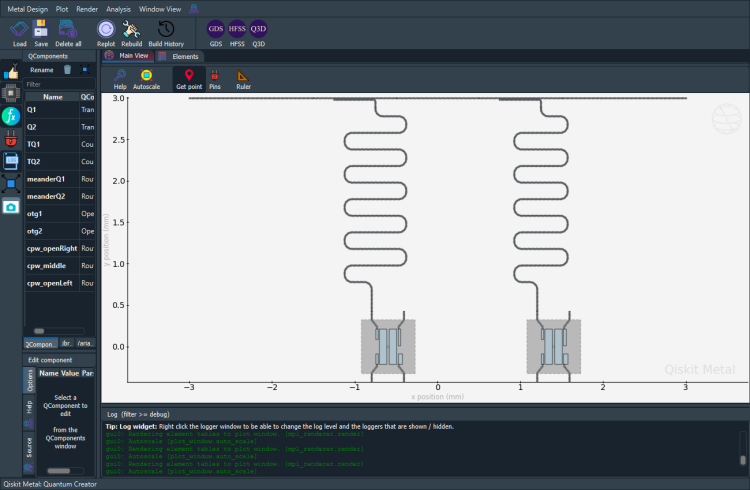

In [9]:
gui.screenshot()

## 2. Render the qubit from Metal into the HangingResonators design in Ansys. <br>ScatteringImpedanceSim will  open the simulation software. Then will connect, activate the design, add a setup.  

Review and update the setup. For driven modal you will need to define not only the simulation convergence parameters, but also the frequency sweep.




In [10]:
em1 = ScatteringImpedanceSim(design, "hfss")

Customizable parameters and default values for HFSS (driven  modal):

    freq_ghz=5 (simulation frequency)
    name="Setup" (setup name)
    max_delta_s=0.1 (absolute value of maximum difference in scattering parameter S)
    max_passes=10 (maximum number of passes)
    min_passes=1 (minimum number of passes)
    min_converged=1 (minimum number of converged passes)
    pct_refinement=30 (percent refinement)
    basis_order=1 (basis order)
    vars (global variables to set in the renderer)
    sweep_setup (all the parameters of the sweep)
    name="Sweep" (name of sweep)
    start_ghz=2.0 (starting frequency)
    stop_ghz=8.0 (stopping frequency)
    count=101 (total number of frequencies)
    step_ghz=None (frequency step size)
    type="Fast" (type of sweep)
    save_fields=False (whether or not to save fields)

In [11]:
# To view the values for defaults. 
em1.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5,
 'max_delta_s': 0.1,
 'max_passes': 10,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'},
 'sweep_setup': {'name': 'Sweep',
  'start_ghz': 2.0,
  'stop_ghz': 8.0,
  'count': 101,
  'step_ghz': None,
  'type': 'Fast',
  'save_fields': False}}

In [12]:
em1.setup.name = "Sweep_DrivenModal_setup"
em1.setup.freq_ghz = 6.0
em1.setup.max_delta_s = 0.05
em1.setup.max_passes = 12
em1.setup.min_passes = 2


Add a frequency sweep to a driven modal setup.<br>
From QHFSSRenderer.add_sweep doc_strings.  Please go to doc_strings to get the latest information.  

Args:<br>
    setup_name (str, optional): Name of driven modal simulation Sweep.
                            Defaults to "Setup".<br>
    start_ghz (float, optional): Starting frequency of sweep in GHz.
                            Defaults to 2.0.<br>
    stop_ghz (float, optional): Ending frequency of sweep in GHz.
                            Defaults to 8.0.<br>
    count (int, optional): Total number of frequencies.
                            Defaults to 101.<br>
    step_ghz (float, optional): Difference between adjacent
                            frequencies. Defaults to None.<br>
    name (str, optional): Name of sweep. Defaults to "Sweep".<br>
    type (str, optional): Type of sweep. Defaults to "Fast".<br>
    save_fields (bool, optional): Whether or not to save fields.
                        Defaults to False.<br>
                        
                        
From pyEPR.HfssSetup.insert_sweep(), please go to this method to get the latest documentation.   
You should provide either step_ghz or count when inserting an HFSS driven model freq sweep. Do not provide both or neither!

In [13]:
# To view the values for defaults. 
em1.setup.sweep_setup

{'name': 'Sweep',
 'start_ghz': 2.0,
 'stop_ghz': 8.0,
 'count': 101,
 'step_ghz': None,
 'type': 'Fast',
 'save_fields': False}

In [14]:
em1.setup.sweep_setup.name="Sweep_options__dm_sweep"
em1.setup.sweep_setup.start_ghz=4.0
em1.setup.sweep_setup.stop_ghz=9.0
em1.setup.sweep_setup.count=5001
em1.setup.sweep_setup.type="Interpolating"


em1.setup

{'name': 'Sweep_DrivenModal_setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 6.0,
 'max_delta_s': 0.05,
 'max_passes': 12,
 'min_passes': 2,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'},
 'sweep_setup': {'name': 'Sweep_options__dm_sweep',
  'start_ghz': 4.0,
  'stop_ghz': 9.0,
  'count': 5001,
  'step_ghz': None,
  'type': 'Interpolating',
  'save_fields': False}}

In [15]:
# Set the buffer width at the edge of the design to be 0.5 mm 
# in both directions.
em1.setup.renderer.options['x_buffer_width_mm'] = 0.5
em1.setup.renderer.options['y_buffer_width_mm'] = 0.5

In [16]:
#     qcomp_name (str): A component that contains the option to be swept.
#     option_name (str): The option within qcomp_name to sweep.
#     option_sweep (list): Each entry in the list is a value for
#                 option_name.
#     qcomp_render (list): The component to render to simulation.
#     open_terminations (list): Identify which kind of pins. Follow the
#                 details from renderer QQ3DRenderer.render_design, or
#                 QHFSSRenderer.render_design.
#     port_list (list): List of tuples of jj's that shouldn't
#                     be rendered.  Follow details from
#                     renderer in QHFSSRenderer.render_design.
#     jj_to_port (list): List of junctions (qcomp, qgeometry_name,
#                         impedance, draw_ind) to render as lumped ports
#                         or as lumped port in parallel with a sheet
#                         inductance.    Follow details from renderer
#                         in QHFSSRenderer.render_design.
#     ignored_jjs (Union[list,None]): This is not used by all renderers,
#                  just hfss.
#     design_name(str): Name of design (workspace) to use in project.
#     box_plus_buffer(bool): Render the entire chip or create a
#                 box_plus_buffer around the components which are rendered.


In [17]:

design_name= "Sweep_DrivenModal"
qcomp_render = [] # Means to render everything in qgeometry table.
open_terminations = []

# Here, pin cpw_openRight_end and cpw_openLeft_end are converted into lumped ports,
#           each with an impedance of 50 Ohms. <br>
port_list = [('cpw_openRight', 'end', 50),
                      ('cpw_openLeft', 'end', 50)]
jj_to_port = [('Q1', 'rect_jj', 50, False)]
# Neither of the junctions in Q1 or Q2 are rendered.
ignored_jjs = [('Q2', 'rect_jj')]
box_plus_buffer = True

In [18]:
#Note: The method will connect to  Ansys simulation, activate_drivenmodal_design(), add_drivenmodal_setup().

all_sweeps, return_code = em1.run_sweep(meanderQ1.name,
                                        'total_length', 
                                        ['9mm', '10mm', '11mm'],
                                        qcomp_render,
                                        open_terminations,
                                        design_name=design_name,
                                        port_list = port_list,
                                        jj_to_port= jj_to_port,
                                        ignored_jjs= ignored_jjs,
                                        box_plus_buffer=box_plus_buffer
                                       )

INFO 08:57AM [connect_project]: Connecting to Ansys Desktop API...
INFO 08:57AM [load_ansys_project]: 	Opened Ansys App
INFO 08:57AM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 08:57AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project24
INFO 08:57AM [connect_design]: No active design found (or error getting active design).
INFO 08:57AM [connect]: 	 Connected to project "Project24". No design detected
INFO 08:57AM [connect_design]: 	Opened active design
	Design:    Sweep_DrivenModal_hfss [Solution type: DrivenModal]
WARNING 08:57AM [connect_setup]: 	No design setup detected.
WARNING 08:57AM [connect_setup]: 	Creating drivenmodal default setup.
INFO 08:57AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 08:58AM [get_setup]: 	Opened setup `Sweep_DrivenModal_setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 08:58AM [get_setup]: 	Opened setup `Sweep_DrivenModal_setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 0

#Note: Sweep again using the arguments from previous run.  
```
all_sweeps_6_7_8, return_code = em1.run_sweep(meanderQ1.name,
                                        'total_length', 
                                        ['6.5mm', '7.5mm', '8.5mm']
                                       )
```

In [19]:

if return_code == 0:
    # Each key corresponds to list passed to ['9mm', '8mm', '7mm']
    print(all_sweeps.keys())
    
    # Each key corresponds to list passed to ['6mm', '5mm', '4mm']
    # print(all_sweeps_6_7_8.keys())
else:
    print('Check warning messages to see why all_sweeps is non-zero.')


dict_keys(['9mm', '10mm', '11mm'])


In [20]:
all_sweeps['9mm'].keys()

dict_keys(['option_name', 'variables'])

In [21]:
all_sweeps['9mm']['variables']

{'sim_setup_name': 'Sweep_DrivenModal_setup',
 'sweep_name': 'Sweep_options__dm_sweep'}

In [22]:
all_sweeps['9mm']['option_name']


'total_length'

In [23]:
print(f"""
project_name = {em1.renderer.pinfo.project_name}
design_name  = {em1.renderer.pinfo.design_name}
setup_name   = {em1.renderer.pinfo.setup_name}
""")


project_name = Project24
design_name  = Sweep_DrivenModal_hfss
setup_name   = Sweep_DrivenModal_setup



Note: Results storage is currently being updated to be fully functional with the sweep functionality.

In [24]:
em1.get_impedance()                # default: ['Z11', 'Z21']

(                        Z11                   Z21
 4.000  -0.000000-11.896548j   0.000000+44.291514j
 4.001   0.000001-11.881640j   0.00000+044.287660j
 4.002   0.000001-11.866735j   0.000000+44.283811j
 4.003   0.000002-11.851833j   0.000000+44.279968j
 4.004   0.000002-11.836933j   0.000000+44.276131j
 ...                     ...                   ...
 8.996  0.000429+233.181228j  0.000398+237.847267j
 8.997  0.000331+233.625173j  0.000307+238.283674j
 8.998  0.000228+234.070780j  0.000211+238.721763j
 8.999  0.000117+234.518060j  0.000109+239.161547j
 9.000 -0.000000+234.967023j -0.000000+239.603035j
 
 [5001 rows x 2 columns],
 <Figure size 3000x1800 with 2 Axes>)

In [25]:
em1.get_admittance()              # default: ['Y11', 'Y21']

(                      Y11                 Y21
 4.000  0.000000-0.006633j -0.000000-0.024359j
 4.001  0.000000-0.006625j  0.000000-0.024357j
 4.002  0.000000-0.006617j  0.000000-0.024355j
 4.003  0.000000-0.006609j  0.000000-0.024352j
 4.004  0.000000-0.006600j  0.000000-0.024350j
 ...                   ...                 ...
 8.996 -0.000000+0.086442j  0.000000-0.088951j
 8.997 -0.000000+0.086555j  0.000000-0.089060j
 8.998 -0.000000+0.086669j  0.000000-0.089169j
 8.999 -0.000000+0.086783j  0.000000-0.089279j
 9.000  0.000000+0.086898j -0.000000-0.089390j
 
 [5001 rows x 2 columns],
 <Figure size 3000x1800 with 2 Axes>)

In [26]:
em1.get_scattering(['S11', 'S21', 'S31'])          ## default: ['S11', 'S21', 'S22']

(                      S11                 S21                 S31
 4.000 -0.147086-0.038897j -0.264193+0.952394j  0.000055+0.000028j
 4.001 -0.147108-0.038852j -0.263887+0.952478j  0.000055+0.000028j
 4.002 -0.147130-0.038806j -0.263581+0.952561j  0.000055+0.000028j
 4.003 -0.147152-0.038761j -0.263275+0.952644j  0.000055+0.000028j
 4.004 -0.147174-0.038715j -0.262969+0.952727j  0.000055+0.000028j
 ...                   ...                 ...                 ...
 8.996  0.005780-0.006204j  0.976020+0.217516j -0.000039+0.000050j
 8.997  0.005783-0.006260j  0.976093+0.217185j -0.000039+0.000050j
 8.998  0.005786-0.006317j  0.976166+0.216855j -0.000039+0.000050j
 8.999  0.005790-0.006373j  0.976239+0.216524j -0.000039+0.000050j
 9.000  0.005793-0.006430j  0.976312+0.216192j -0.000039+0.000050j
 
 [5001 rows x 3 columns],
 <Figure size 3000x1800 with 2 Axes>)

In [27]:
dataframe_scattering = em1.get_scattering(['S11', 'S21', 'S31'])
df_s = dataframe_scattering[0]

In [28]:
s11 = df_s['S11']
s11

s21 = df_s['S21']
s21

s31 = df_s['S31']
s31

4.000    0.000055+0.000028j
4.001    0.000055+0.000028j
4.002    0.000055+0.000028j
4.003    0.000055+0.000028j
4.004    0.000055+0.000028j
                ...        
8.996   -0.000039+0.000050j
8.997   -0.000039+0.000050j
8.998   -0.000039+0.000050j
8.999   -0.000039+0.000050j
9.000   -0.000039+0.000050j
Name: S31, Length: 5001, dtype: complex128

In [29]:
dataframe_scattering[0]['20_log_of_mag_S11']= 20 * np.log10(np.absolute(s11))
dataframe_scattering[0]['20_log_of_mag_S21']= 20 * np.log10(np.absolute(s21))
dataframe_scattering[0]['20_log_of_mag_S31']= 20 * np.log10(np.absolute(s31))
dataframe_scattering[0]

,S11,S21,S31,20_log_of_mag_S11,20_log_of_mag_S21,20_log_of_mag_S31
4.000,-0.147086-0.038897j,-0.264193+0.952394j,0.000055+0.000028j,-16.355031,-0.101708,-84.181500
4.001,-0.147108-0.038852j,-0.263887+0.952478j,0.000055+0.000028j,-16.354476,-0.101722,-84.199503
4.002,-0.147130-0.038806j,-0.263581+0.952561j,0.000055+0.000028j,-16.353923,-0.101735,-84.217446
4.003,-0.147152-0.038761j,-0.263275+0.952644j,0.000055+0.000028j,-16.353370,-0.101748,-84.235327
4.004,-0.147174-0.038715j,-0.262969+0.952727j,0.000055+0.000028j,-16.352819,-0.101761,-84.253149
...,...,...,...,...,...,...
8.996,0.005780-0.006204j,0.976020+0.217516j,-0.000039+0.000050j,-41.433315,-0.000314,-83.990805
8.997,0.005783-0.006260j,0.976093+0.217185j,-0.000039+0.000050j,-41.388457,-0.000317,-83.990549
8.998,0.005786-0.006317j,0.976166+0.216855j,-0.000039+0.000050j,-41.343861,-0.000319,-83.990273
8.999,0.005790-0.006373j,0.976239+0.216524j,-0.000039+0.000050j,-41.299529,-0.000322,-83.989977


In [30]:
# Reference to current axis. 
magnitude = plt.figure('Magnitude S11, S21, and S31')
plt.clf()
axis = plt.gca() # Get current axis.
dataframe_scattering[0].plot(kind = 'line', y='20_log_of_mag_S11', color = 'green', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='20_log_of_mag_S21', color = 'blue', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='20_log_of_mag_S31', color = 'red', ax = axis)
plt.title(f'S-Parameter Magnitude')
plt.xlabel(f'frequency [GHZ]')
plt.ylabel(f'|S11|,|S21|,|S31| [dB]')
magnitude.show()

In [31]:
# Data is shown as degrees.  
# However, if you want radians, change value of deg to false, deg=False.
dataframe_scattering[0]['degrees_S11'] = np.angle(s11, deg=True)
dataframe_scattering[0]['degrees_S21'] = np.angle(s21, deg=True)
dataframe_scattering[0]['degrees_S31'] = np.angle(s31, deg=True)
dataframe_scattering[0]

,S11,S21,S31,20_log_of_mag_S11,20_log_of_mag_S21,20_log_of_mag_S31,degrees_S11,degrees_S21,degrees_S31
4.000,-0.147086-0.038897j,-0.264193+0.952394j,0.000055+0.000028j,-16.355031,-0.101708,-84.181500,-165.187158,105.503950,27.027756
4.001,-0.147108-0.038852j,-0.263887+0.952478j,0.000055+0.000028j,-16.354476,-0.101722,-84.199503,-165.205819,105.485570,27.012771
4.002,-0.147130-0.038806j,-0.263581+0.952561j,0.000055+0.000028j,-16.353923,-0.101735,-84.217446,-165.224480,105.467191,26.997785
4.003,-0.147152-0.038761j,-0.263275+0.952644j,0.000055+0.000028j,-16.353370,-0.101748,-84.235327,-165.243140,105.448812,26.982800
4.004,-0.147174-0.038715j,-0.262969+0.952727j,0.000055+0.000028j,-16.352819,-0.101761,-84.253149,-165.261801,105.430433,26.967815
...,...,...,...,...,...,...,...,...,...
8.996,0.005780-0.006204j,0.976020+0.217516j,-0.000039+0.000050j,-41.433315,-0.000314,-83.990805,-47.027252,12.563626,128.377355
8.997,0.005783-0.006260j,0.976093+0.217185j,-0.000039+0.000050j,-41.388457,-0.000317,-83.990549,-47.269117,12.544227,128.350189
8.998,0.005786-0.006317j,0.976166+0.216855j,-0.000039+0.000050j,-41.343861,-0.000319,-83.990273,-47.509012,12.524818,128.322852
8.999,0.005790-0.006373j,0.976239+0.216524j,-0.000039+0.000050j,-41.299529,-0.000322,-83.989977,-47.746983,12.505400,128.295342


In [32]:
# Reference to current axis. 
phase = plt.figure('Phase of S11 and S21')
plt.clf()
axis = plt.gca() # Get current axis.
dataframe_scattering[0].plot(kind = 'line', y='degrees_S11', color = 'green', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='degrees_S21', color = 'blue', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='degrees_S31', color = 'red', ax = axis)
plt.title(f'S-Parameter Phase')
plt.xlabel(f'frequency [GHZ]')
plt.ylabel(f'<S11, <S21, <S31 [degrees]')
phase.show()

In [33]:
em1.close()

In [34]:
# Uncomment next line if you would like to close the gui
# gui.main_window.close()